https://www.kaggle.com/competitions/playground-series-s5e4

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# original_df = pd.read_csv('original.csv')
# original_df = original_df[original_df['Listening_Time_minutes'].notna()]

# Preprocess

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [6]:
train_df.isna().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [7]:
def clean_data(df):
    
    # not more two ads
    df.loc[df['Number_of_Ads']>2, 'Number_of_Ads'] = 2
    
    # not more 120 Length
    df.loc[df['Episode_Length_minutes']>120, 'Number_of_Ads'] = 120
    
    return df

In [8]:
def episode_to_int(df):
    
    df['Episode_Title'] = df['Episode_Title'].str.split(' ').str[1].astype('int')
    
    return df

In [9]:
def fillna_mean(df):
    
    df['Episode_Length_minutes'] = df['Episode_Length_minutes'].fillna(train_df['Episode_Length_minutes'].mean())
    df['Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].fillna(train_df['Guest_Popularity_percentage'].mean())
    
    return df

In [10]:
def fillna_zero(df):
    
    df['Number_of_Ads'] = df['Number_of_Ads'].fillna(0)
    
    return df

In [11]:
train_df = clean_data(train_df)
train_df = episode_to_int(train_df)
train_df = fillna_mean(train_df)
train_df = fillna_zero(train_df)

In [12]:
train_df.isna().sum().sum()

0

In [13]:
feature_values = list(train_df.drop(columns=['id', 'Listening_Time_minutes']).columns)
target_value = 'Listening_Time_minutes'

In [14]:
feature_cat = list(train_df[feature_values].select_dtypes(include=['object']).columns)
feature_num = list(train_df[feature_values].select_dtypes(exclude=['object']).columns)

## Split data

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df[feature_values],
                                                    train_df[target_value],
                                                    test_size=0.2,
                                                    random_state=42)

In [17]:
# add mean/std/min/max in group

if True:
    
    X_train_t = X_train.copy()
    X_train_t['target'] = y_train
    
    df_l_metrics = []
    
    
    for cat in feature_cat:
        
        X_train_t_1 = (
            X_train_t.groupby([cat], as_index=False)
            .agg(mean=('target', np.mean),
                 min=('target', np.min),
                 max=('target', np.max),
                 std=('target', np.std))
            .rename(columns={'mean': (cat+'_mean'),
                             'min': (cat+'_min'),
                             'max': (cat+'_max'),
                             'std': (cat+'_std')})
        )
        
        df_l_metrics = df_l_metrics + [X_train_t_1]
        
        
    for df_t in df_l_metrics:
        X_train = X_train.merge(df_t, how='left', on=df_t.columns[0], validate='m:1')
        X_test = X_test.merge(df_t, how='left', on=df_t.columns[0], validate='m:1')        

#### Препроцессоры для разных моделей

In [18]:
scaler = StandardScaler()
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [19]:
# классический
preprocessor_none = ColumnTransformer([
    ('num', 'passthrough', feature_num),
    ('cat', 'passthrough', feature_cat)
])

In [20]:
# только категориальные данные
preprocessor_ohe = ColumnTransformer([
    ('num', 'passthrough', feature_num),
    ('cat', ohe, feature_cat)
])

In [21]:
# категориальные данные и стандартизация
preprocessor_scaled_ohe = ColumnTransformer([
    ('num', scaler, feature_num),
    ('cat', ohe, feature_cat)
])

In [22]:
X_none_train = pd.DataFrame(
    preprocessor_none.fit_transform(X_train),
    columns=feature_num + feature_cat
)

X_none_test = pd.DataFrame(
    preprocessor_none.transform(X_test),
    columns=feature_num + feature_cat
)

In [23]:
preprocessor_ohe.fit(X_train)
ohe_cols = preprocessor_ohe.named_transformers_['cat'].get_feature_names_out(feature_cat)

X_ohe_train = pd.DataFrame(
    preprocessor_ohe.transform(X_train),
    columns=feature_num + list(ohe_cols)
)

X_ohe_test = pd.DataFrame(
    preprocessor_ohe.transform(X_test),
    columns=feature_num + list(ohe_cols)
)

In [24]:
preprocessor_scaled_ohe.fit(X_train)
scaled_ohe_cols = preprocessor_scaled_ohe.named_transformers_['cat'].get_feature_names_out(feature_cat)

X_scaled_ohe_train = pd.DataFrame(
    preprocessor_scaled_ohe.transform(X_train),
    columns=feature_num + list(scaled_ohe_cols)
)

X_scaled_ohe_test = pd.DataFrame(
    preprocessor_scaled_ohe.transform(X_test),
    columns=feature_num + list(scaled_ohe_cols)
)

# FIT

### Catboost

In [34]:
from catboost import CatBoostRegressor
import optuna

In [25]:
def objective(trial):
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        
        'task_type': 'GPU',
        'devices':'0',
        
        'random_seed': 42,
        'cat_features': feature_cat,
        'verbose': 0,
        'early_stopping_rounds': 20,
        
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 12),
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        
        #'bootstrap_type': 'Bayesian',
        #'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        #'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0)        
    }

    model = CatBoostRegressor(**params)

    # cv
    scores = []
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(X_none_train, y_train):
        X_train_t, X_val = X_none_train.iloc[train_idx], X_none_train.iloc[val_idx]
        y_train_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_t, y_train_t,
                  eval_set=[(X_val, y_val)],
                  verbose=0)

        preds = model.predict(X_val)
        score = mean_squared_error(y_val, preds)**0.5
        scores.append(score)

    return np.mean(scores)

In [26]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

In [27]:
# to fit
model_0_lvl_cb = CatBoostRegressor(
    loss_function='RMSE',    
    eval_metric='RMSE',
    
    verbose=0,
    early_stopping_rounds=10,
    
    task_type='GPU',
    devices='0',
    
    cat_features=feature_cat,
    random_seed=42,
    
    iterations=2044,
    depth=12,
    learning_rate=0.02983222687752797,
    l2_leaf_reg=4.229648612417207,
    random_strength=0.7357592862553951
    
)

# model_0_lvl_cb.fit(X=X_none_train, y=y_train, eval_set=(X_none_test, y_test))

In [28]:
scores = []
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_none_train, y_train):
    X_train_t, X_val = X_none_train.iloc[train_idx], X_none_train.iloc[val_idx]
    y_train_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model_0_lvl_cb.fit(X_train_t, y_train_t, verbose=500)

    preds = model_0_lvl_cb.predict(X_val)
    score = mean_squared_error(y_val, preds)**0.5
    scores.append(score)
    print(score)
    
np.mean(scores)

0:	learn: 26.5307505	total: 203ms	remaining: 6m 54s
500:	learn: 12.7307407	total: 1m 16s	remaining: 3m 54s
1000:	learn: 12.2505351	total: 2m 31s	remaining: 2m 38s
1500:	learn: 11.7695403	total: 3m 48s	remaining: 1m 22s
2000:	learn: 11.3278943	total: 5m 5s	remaining: 6.57s
2043:	learn: 11.2873739	total: 5m 12s	remaining: 0us
13.023251574076188
0:	learn: 26.5292020	total: 157ms	remaining: 5m 19s
500:	learn: 12.7195597	total: 1m 18s	remaining: 4m 2s
1000:	learn: 12.2086359	total: 2m 36s	remaining: 2m 42s
1500:	learn: 11.7385472	total: 3m 54s	remaining: 1m 24s
2000:	learn: 11.2833094	total: 5m 12s	remaining: 6.71s
2043:	learn: 11.2436876	total: 5m 18s	remaining: 0us
13.047160262806736
0:	learn: 26.5452203	total: 169ms	remaining: 5m 44s
500:	learn: 12.7406428	total: 1m 17s	remaining: 3m 59s
1000:	learn: 12.2319054	total: 2m 34s	remaining: 2m 41s
1500:	learn: 11.7612176	total: 3m 55s	remaining: 1m 25s
2000:	learn: 11.3236664	total: 5m 13s	remaining: 6.74s
2043:	learn: 11.2854464	total: 5m 20

13.044430435791222

### Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
def objective(trial):
    params = {
        'criterion': 'squared_error',
        'random_state': 42,
        'n_jobs': -1,
        
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        
        'bootstrap': True,
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }

    model = RandomForestRegressor(**params)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    scores = []
    for train_index, test_index in kf.split(X_ohe_train, y_train):
        X_train_t, X_val = X_ohe_train.iloc[train_index], X_ohe_train.iloc[test_index]
        y_train_t, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model.fit(X_train_t, y_train_t)
        
        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds)**0.5
        scores.append(rmse)

    return np.mean(scores)

In [31]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

In [32]:
# to fit
model_0_lvl_rf = RandomForestRegressor(
    criterion='squared_error',
    random_state=42,
    n_jobs=-1,

    n_estimators=350, # 166
    max_depth=19,

    min_samples_split=18,
    min_samples_leaf=6,

    bootstrap=True,
    max_samples=0.9743737658020362,
    max_features='auto'
)

In [33]:
scores = []
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_ohe_train, y_train):
    X_train_t, X_val = X_ohe_train.iloc[train_idx], X_ohe_train.iloc[val_idx]
    y_train_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model_0_lvl_rf.fit(X_train_t, y_train_t)

    preds = model_0_lvl_rf.predict(X_val)
    score = mean_squared_error(y_val, preds)**0.5
    scores.append(score)
    print(score)
    
np.mean(scores)

12.952903671737314
12.975418034191236
12.993898920562348


12.974073542163632

### ElasticNet

In [35]:
from sklearn.linear_model import ElasticNet

In [36]:
def objective(trial):
    
    alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_index, val_index in kf.split(X_scaled_ohe_train, y_train):
        X_train_t, X_val = X_scaled_ohe_train.iloc[train_index], X_scaled_ohe_train.iloc[val_index]
        y_train_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_t, y_train_t)
        
        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds)**0.5
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [37]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

In [38]:
# to fit
model_0_lvl_elastic = ElasticNet(
    alpha=0.0010932638057139722,
    l1_ratio=0.981896155656566,
    random_state=42)

In [39]:
scores = []
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_scaled_ohe_train, y_train):
    X_train_t, X_val = X_scaled_ohe_train.iloc[train_idx], X_scaled_ohe_train.iloc[val_idx]
    y_train_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model_0_lvl_elastic.fit(X_train_t, y_train_t)

    preds = model_0_lvl_elastic.predict(X_val)
    score = mean_squared_error(y_val, preds)**0.5
    scores.append(score)
    print(score)
    
np.mean(scores)

13.390134128327661
13.397385003031262
13.432936309243017


13.406818480200647

### Stacking

In [40]:
from sklearn.linear_model import Ridge

In [41]:
# модели 0 уровня
base_models = [
    ('cb', model_0_lvl_cb, X_none_train, X_none_test),
    ('rf', model_0_lvl_rf, X_ohe_train, X_ohe_test),
    ('elastic', model_0_lvl_elastic, X_scaled_ohe_train, X_scaled_ohe_test)
]

In [42]:
# KFold setup
kf = KFold(n_splits=4, shuffle=True, random_state=42)

meta_features = np.zeros((X_train.shape[0], len(base_models)))
meta_feature_names = [name for name, _, _, _ in base_models]

In [43]:
%%time

# OOF прогноз для мета модели
for i, (name, model, X_train_full, X_test_full) in enumerate(base_models):
    iter_ = 0
    for train_idx, valid_idx in kf.split(X_train):
        X_train_part, X_valid_part = X_train_full.iloc[train_idx], X_train_full.iloc[valid_idx]
        y_train_part = y_train.iloc[train_idx]

        model.fit(X_train_part, y_train_part)
        
        preds = model.predict(X_valid_part)
        meta_features[valid_idx, i] = preds
        
        iter_ += 1
        print('Done', name, iter_)

Done cb 1
Done cb 2
Done cb 3
Done cb 4
Done rf 1
Done rf 2
Done rf 3
Done rf 4
Done elastic 1
Done elastic 2
Done elastic 3
Done elastic 4
CPU times: total: 3h 30min 42s
Wall time: 47min 12s


In [44]:
# to DataFrame
meta_df = pd.DataFrame(meta_features, columns=meta_feature_names)

In [45]:
# стандартизация метамодели
scaler_meta = StandardScaler()
meta_features_scaled = scaler_meta.fit_transform(meta_df)

In [46]:
meta_df.loc[:] = meta_features_scaled

In [47]:
def objective(trial):
    
    alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)

    model = Ridge(alpha=alpha, random_state=42)

    kf = KFold(n_splits=3, shuffle=True, random_state=45)
    rmse_scores = []
    
    for train_index, val_index in kf.split(meta_df, y_train):
        X_train_t, X_val = meta_df.iloc[train_index], meta_df.iloc[val_index]
        y_train_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_t, y_train_t)
        
        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds)**0.5
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [48]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

In [49]:
# Train meta-model
meta_model = Ridge(alpha=1.5250250687330842)
meta_model.fit(meta_features_scaled, y_train)

Ridge(alpha=1.5250250687330842)

In [50]:
# переобучение моделей 0 уровня
for name, model, X_train_full, _ in base_models:
    model.fit(X_train_full, y_train)
    print(name)

cb
rf
elastic


In [51]:
# финальный прогноз на тестовом датасете
final_test_preds = np.column_stack([
    model.predict(X_test_full)
    for _, model, _, X_test_full in base_models
])
stacked_test_preds = meta_model.predict(scaler_meta.transform(final_test_preds))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [53]:
# оценка модели
mae_test = mean_absolute_error(y_test, stacked_test_preds)
r2_test = r2_score(y_test, stacked_test_preds)
rmse_test = np.sqrt(mean_squared_error(y_test, stacked_test_preds))

print(f'MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R2: {r2_test:.2f}')

MAE: 9.26, RMSE: 12.83, R2: 0.78


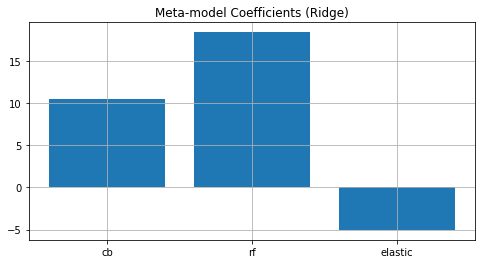

In [60]:
# Коэффициенты метамодели
plt.figure(figsize=(8, 4))
plt.bar(meta_feature_names, meta_model.coef_)
plt.title('Meta-model Coefficients (Ridge)')
plt.grid(True)
plt.show()

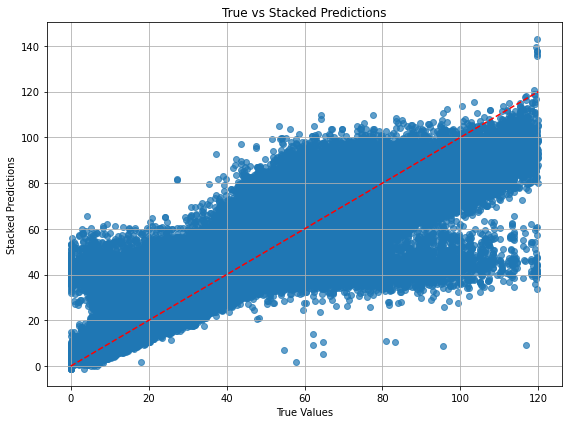

In [63]:
# прогноз vs факт
plt.figure(figsize=(8, 6))
plt.scatter(y_test, stacked_test_preds, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Stacked Predictions")
plt.title("True vs Stacked Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

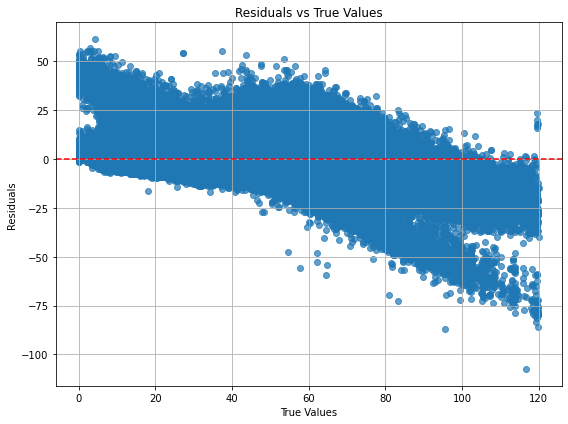

In [65]:
# ошибка
residuals = stacked_test_preds - y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.title("Residuals vs True Values")
plt.grid(True)
plt.tight_layout()
plt.show()

# Predict

In [67]:
test_df_pred = test_df.copy()

In [68]:
test_df_pred = clean_data(test_df_pred)
test_df_pred = episode_to_int(test_df_pred)
test_df_pred = fillna_mean(test_df_pred)

In [69]:
for df_t in df_l_metrics:
    test_df_pred = test_df_pred.merge(df_t, how='left', on=df_t.columns[0], validate='m:1')  

In [70]:
X_test_none_new = pd.DataFrame(preprocessor_none.transform(test_df_pred), columns=feature_num + feature_cat)
X_test_ohe_new = pd.DataFrame(preprocessor_ohe.transform(test_df_pred), columns=feature_num + list(ohe_cols))
X_test_scaled_ohe_new = pd.DataFrame(preprocessor_scaled_ohe.transform(test_df_pred), columns=feature_num + list(scaled_ohe_cols))

In [71]:
# прогнз базовых моделей
base_preds_new = np.column_stack([
    model.predict(
        X_test_ohe_new if name == "rf" else
        X_test_none_new if name == "cb" else
        X_test_scaled_ohe_new
    ) for name, model, _, _ in base_models
])

In [72]:
# прогноз метамодели
stacked_new_preds = meta_model.predict(scaler_meta.transform(base_preds_new))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [73]:
out_df = test_df_pred[['id']].copy()
out_df['Listening_Time_minutes'] = stacked_new_preds

In [ ]:
out_df.to_csv('stacked.csv', index=False)